In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.isri import ISRIStemmer
import nltk
import argparse
import qalsadi.lemmatizer 
from snowballstemmer import stemmer

## Data Preparation 

### Anonymization
First Data was anonymized before touching dvc
name columns removed and sheets with testimonies selected

### Feature Selection
Now bulk of preprocessing (this script is a part of the dvc pipeline)
- Read all the individual excel sheets that we pulled out in the anonymization step
- Pull out the text columns and concatenate them into one for each sheet
- Stack all of the concatenated dataframes on top of each other
- Remove empty strings
- This was a mess because the data was a mess

## Keywords

### Preprocessing
Make sure Arabic data column is of type string
Then we go into the painstaking process of cleaning up Arabic data
I found a package that did it but doing it manually through a series of constructed functions gave me more control 
Remove punctuation
Remove diacritics
Normalize the text by getting rid of spelling inconsistencies and removing duplicates

Stopwords were pulled from a long list compiled by github user Moha Taher https://github.com/mohataher/arabic-stop-words/blob/master/list.txt  

I then created a tokenizer that included lemmatization to bring (at least some) of the words down to their roots. It dind't work so well on dialect but common words between standard formal Arabic and Egyptian colloquial were lemmatized

Used a tfidf vectorizer with the tokenizer I made and ngram range of (1,2) to capture bigrams and unigrams, a min_df of 5 to filter out super rare words and a max_df of 0.8 to filter out super common words

### Visualization- Bar Chart 

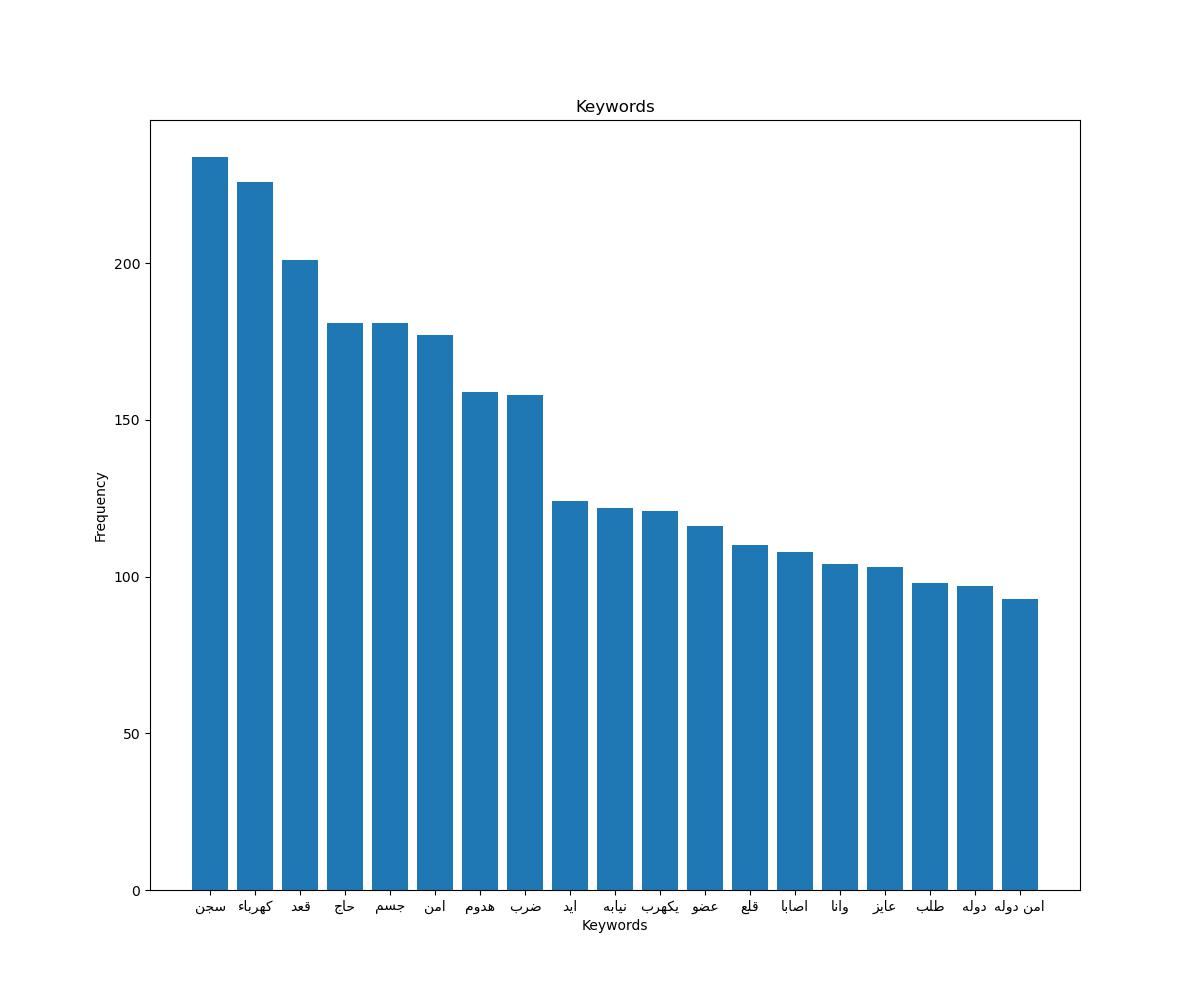

In [84]:
# bar chart
from IPython.display import Image
Image(filename='keywords_barchart.jpg') 

The bar chart was made to work with Arabic text using the arabic reshaper and bidi.algorithm packages

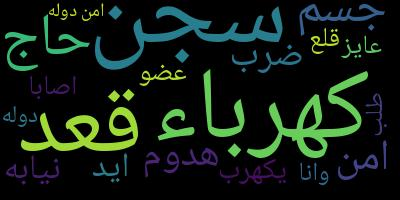

In [85]:
# word cloud
Image(filename='wordcloud.jpg') 

The word cloud was also created using a combination of the arabic reshaper and bidi.algorithm packages 

Analysis: These are actually pretty important words and give you a good sense of what exactly our data is about. 
The top words translate to: State Security, State, Request, Want, Struck/Injured, Undressed, Electrocuted, Prosecutoin, Hand, Hit, Body, and Prison.

It's not perfect- there are a couple of words repeated in various forms- but overall it's much better than I expected it to be

## Topic Modeling

In [86]:
from bertopic import BERTopic

First I tried to use AraVec for the arabic word embeddings and that failed miserabley
Instead I used arabert's word embeddings and that actually worked really well

In [90]:
# load the trained model and display 
topic_model = BERTopic.load("arabert_model")

In [91]:
# load data
testimonies = pd.read_csv("Data/testimonies.csv")
testimonies['أقوال بالتعرض للتعذيب'] = testimonies['أقوال بالتعرض للتعذيب'].astype(str)

In [92]:
topics, probabilities = topic_model.fit_transform(list(testimonies['أقوال بالتعرض للتعذيب']))

2022-05-09 15:07:27,493 - BERTopic - Transformed documents to Embeddings
2022-05-09 15:07:31,268 - BERTopic - Reduced dimensionality with UMAP
2022-05-09 15:07:31,320 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [93]:
# print the topics
topic_model.get_topic_info()

,Topic,Count,Name
0,0,413,0_nan_nan nan_ممنوع_ممنوع ممنوع
1,1,255,1_في_علي_من_جسمي
2,2,69,2_إصابات_من_وبسؤاله_في
3,3,65,3_عايز_بطلب_أهلي_زيارة
4,-1,59,-1_من_في_السجن_على
5,4,46,4_في_فى_من_علي
6,5,41,5_السجن_من_بطلب_في
7,6,24,6_لمس أعضاءها_اثناء التحقيق_وتهديدها بالاغتصاب...
8,7,23,7_ده_اللي_في_حاجة
9,8,22,8_اتعرض علي_علي_اتعرض_عندي


In [94]:
# visualize the top words of each topic
topic_model.visualize_barchart()

These topics are actually pretty illustrative. 
Topic Categories:
- -1: General prison and prosecution related terms
- 1: Bodily harm or ailments
- 2: Interrogations
- 3: Denial of Family Visitation
- 4: Seems just like number 1- bodily harm or ailement
- 5: Mistreatment
- 6: Sexual Vilence
- 7: Colloquial words not in stop words
- 8: Subjection to Torture
- 9: Unclear
- 10: Locations

The divisions aren't super clean and it could definitely benefit from some additional pruning but overal these are categories that make sense

In [95]:
# this heatmap shows the level of similiraity between topics
topic_model.visualize_heatmap()

They're all pretty highly correlated which makes sense as abuses trend to track together. 

In [102]:
topic_model.visualize_topics([1,2,3,4,5,6,7,8,9])

Two main clusters break out by physical abuse and mental/social abuse

In [97]:
# hierarchical clustering
topic_model.visualize_hierarchy()